# Number of serious reports per year

/var/folders/5g/yyzx5_551v1dz53h3hnm2nmw0000gn/T/ipykernel_36637/1242591090.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}'.format(y/1000) for y in ax.get_yticks()])


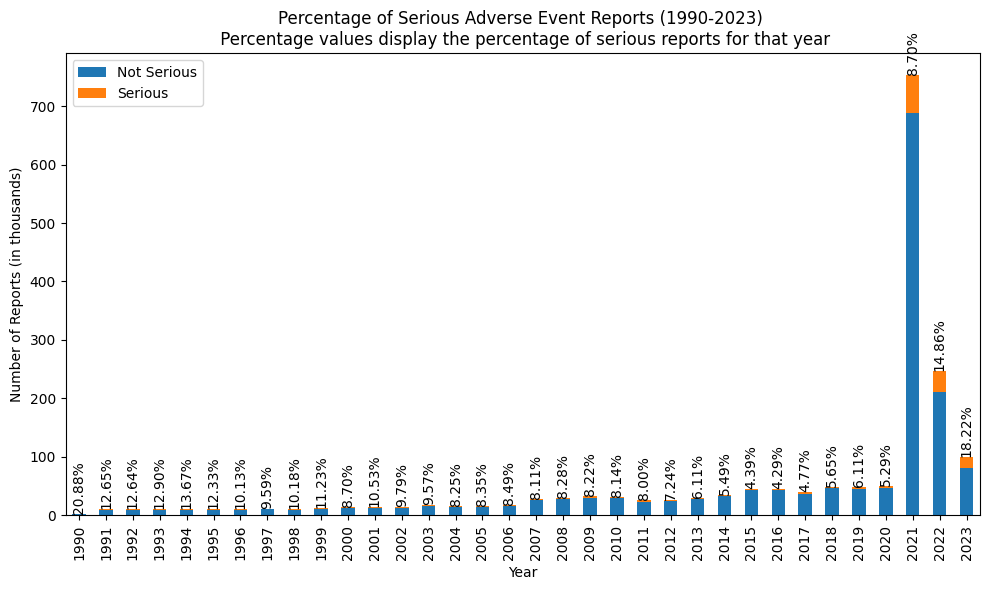

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the columns that indicate a serious report
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize a DataFrame to store the aggregated counts
aggregated_counts = pd.DataFrame(index=range(1990, 2024), columns=['Serious', 'Not Serious'])

for year in range(1990, 2024):
    # Construct the file name
    filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    
    # Load the data
    data = pd.read_csv(filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
    
    # Count serious entries (entries with 'Y' in any of the serious columns)
    serious_count = (data == 'Y').any(axis=1).sum()
    total_count = len(data)
    
    # Store the counts
    aggregated_counts.loc[year, 'Serious'] = serious_count
    aggregated_counts.loc[year, 'Not Serious'] = total_count - serious_count

# Calculate percentages
aggregated_counts['Percentage'] = (aggregated_counts['Serious'] / (aggregated_counts['Serious'] + aggregated_counts['Not Serious'])) * 100

# Plotting
plt.figure(figsize=(10, 6))
# Plot 'Serious' on top of 'Not Serious'
ax = aggregated_counts[['Not Serious', 'Serious']].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Percentage of Serious Adverse Event Reports (1990-2023) \n Percentage values display the percentage of serious reports for that year')
plt.xlabel('Year')
plt.ylabel('Number of Reports (in thousands)')
plt.legend(['Not Serious', 'Serious'])

# Adjust y-axis to show values in thousands
ax.set_yticklabels(['{:.0f}'.format(y/1000) for y in ax.get_yticks()])

# Annotating with percentages
for year, row in aggregated_counts.iterrows():
    # Calculate the position for annotation
    position = row['Not Serious'] + row['Serious']
    # Annotate with the percentage
    ax.annotate(f'{row["Percentage"]:.2f}%', (year-1990, position), ha='center', va='bottom', rotation=90)
    
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_per_Year.png')
plt.show()


### For all years

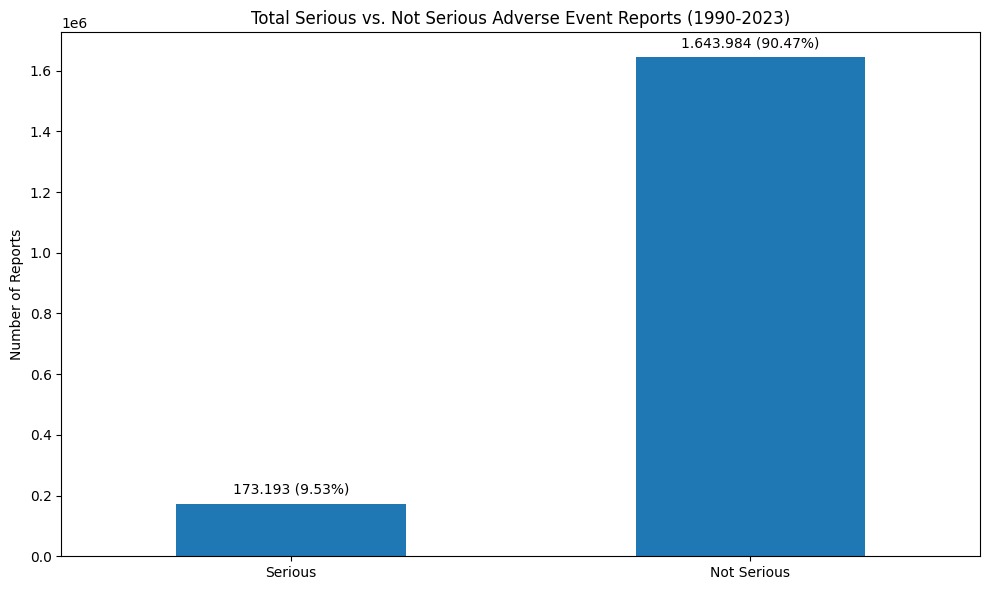

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the columns that indicate a serious report
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize counters for serious and not serious reports
total_serious = 0
total_not_serious = 0

for year in range(1990, 2024):
    # Construct the file name
    filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    
    # Load the data
    data = pd.read_csv(filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
    
    # Count serious entries (entries with 'Y' in any of the serious columns)
    serious_count = (data == 'Y').any(axis=1).sum()
    not_serious_count = len(data) - serious_count
    
    # Update the total counts
    total_serious += serious_count
    total_not_serious += not_serious_count

# Create a DataFrame for plotting
counts_df = pd.DataFrame({'Count': [total_serious, total_not_serious]}, index=['Serious', 'Not Serious'])

# Calculate the percentage
total_reports = total_serious + total_not_serious
counts_df['Percentage'] = (counts_df['Count'] / total_reports) * 100

# Plotting
plt.figure(figsize=(10, 6))
ax = counts_df['Count'].plot(kind='bar', legend=False, ax=plt.gca())
plt.title('Total Serious vs. Not Serious Adverse Event Reports (1990-2023)')
plt.ylabel('Number of Reports')
plt.xticks(rotation=0)

# Custom function to format number with period as thousand separator
def format_with_period(number):
    return format(number, ",d").replace(",", ".")

# Annotating with counts and percentages
for idx, p in enumerate(ax.patches):
    count = int(counts_df.iloc[idx]['Count'])  # Convert to integer
    formatted_count = format_with_period(count)
    label = f"{formatted_count} ({counts_df.iloc[idx]['Percentage']:.2f}%)"
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_all_Years.png')
plt.show()


## For COVID-19 vaccines

/var/folders/5g/yyzx5_551v1dz53h3hnm2nmw0000gn/T/ipykernel_36637/265994626.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y/1000):,d}' for y in yticks])


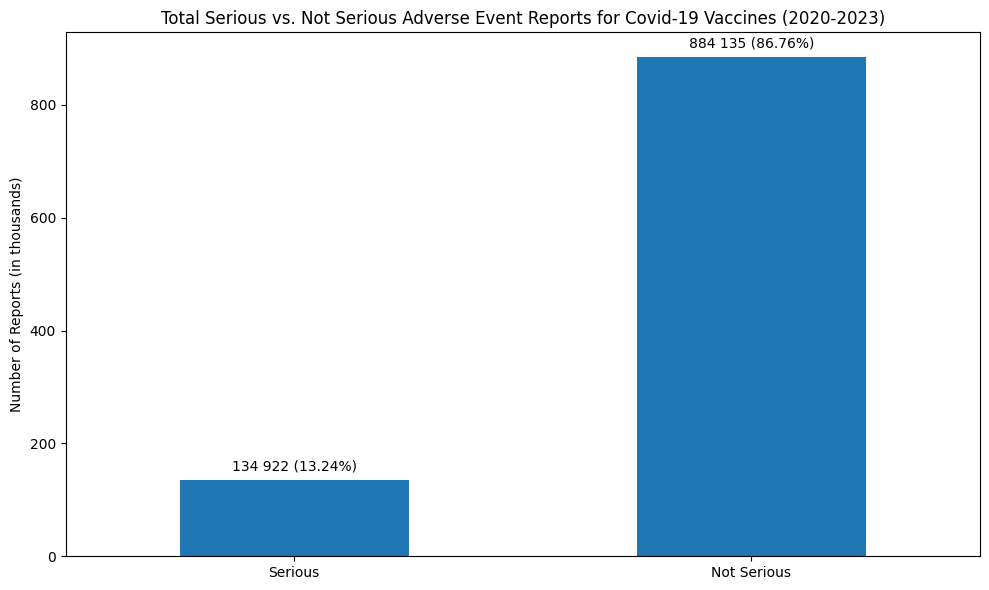

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

serious_columns = ['VAERS_ID', 'DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']
total_serious = 0
total_not_serious = 0

for year in range(2020, 2024):
    # File paths
    data_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    vax_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
    
    # Load datasets (only necessary columns for VAERSDATA)
    data_df = pd.read_csv(data_filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
    vax_df = pd.read_csv(vax_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])
    
    # Filter VAERSVAX for COVID19
    covid_vax_df = vax_df[vax_df['VAX_TYPE'] == 'COVID19']
    
    # Merge datasets on VAERS_ID
    merged_df = pd.merge(data_df, covid_vax_df, on='VAERS_ID')
    
    # Count serious and not serious entries
    serious_count = (merged_df[serious_columns[1:]] == 'Y').any(axis=1).sum()
    total_count = len(merged_df)
    
    # Update totals
    total_serious += serious_count
    total_not_serious += total_count - serious_count

# Create a DataFrame for plotting
counts_df = pd.DataFrame({'Count': [total_serious, total_not_serious]}, index=['Serious', 'Not Serious'])

# Calculate the percentage
total_reports = total_serious + total_not_serious
counts_df['Percentage'] = (counts_df['Count'] / total_reports) * 100

# Plotting
# Plotting
plt.figure(figsize=(10, 6))
ax = counts_df['Count'].plot(kind='bar', legend=False, ax=plt.gca())
plt.title('Total Serious vs. Not Serious Adverse Event Reports for Covid-19 Vaccines (2020-2023)')
plt.ylabel('Number of Reports (in thousands)')
plt.xticks(rotation=0)

# Custom function to format number with period as thousand separator
def format_with_period(number):
    return format(number, ",d").replace(",", " ")

# Annotating with counts and percentages
for idx, p in enumerate(ax.patches):
    count = int(counts_df.iloc[idx]['Count'])  # Convert to integer
    formatted_count = format_with_period(count)
    label = f"{formatted_count} ({counts_df.iloc[idx]['Percentage']:.2f}%)"
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Divide y-axis tick labels by 1,000
yticks = ax.get_yticks()
ax.set_yticklabels([f'{int(y/1000):,d}' for y in yticks])
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_Covid19_Vaccines.png')
plt.show()